In [1]:
RANDOM_SEED = 42

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import QuantileTransformer

In [3]:
BENIGN_LABEL = 0
ANOMALY_LABEL = 1

In [4]:
train_stage_1_3_OCSVM = pd.read_csv("data/train_stage_1_3_OCSVM.csv")

X_train = train_stage_1_3_OCSVM.drop(columns=["Label", "Unnamed: 0"])
y_train = np.ones(len(train_stage_1_3_OCSVM["Label"])) * BENIGN_LABEL

del train_stage_1_3_OCSVM

In [5]:
X_train.shape

(10000, 66)

In [6]:
validation_stage_1_3 = pd.read_csv("data/validation_stage_1_3.csv")

X_val = validation_stage_1_3.drop(columns=["Label", "Unnamed: 0"])
y_val = np.where(validation_stage_1_3["Label"] == "BENIGN", BENIGN_LABEL, ANOMALY_LABEL)
print(X_val.shape)
del validation_stage_1_3

(136305, 66)


In [7]:
# Optimized pipelines

stage1 = Pipeline(
                    [('scaler', QuantileTransformer(output_distribution='normal', subsample=100000)),
                    ('pca', PCA(n_components= 40)),
                    ('ocsvm',OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151))]
                )

stage1.fit(X_train)

Pipeline(steps=[('scaler',
                 QuantileTransformer(output_distribution='normal',
                                     subsample=100000)),
                ('pca', PCA(n_components=40)),
                ('ocsvm',
                 OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151))])

In [8]:
y_pred_train = stage1.predict(X_train) #marcando 1 como benigno
np.unique(y_pred_train, return_counts=True)

(array([-1,  1], dtype=int64), array([1468, 8532], dtype=int64))

In [9]:
y_score_train = stage1.score_samples(X_train)
y_score_train.min(),y_score_train.max()

(0.0043285808718259555, 0.007897651867723995)

In [10]:
y_pred = stage1.predict(X_val)
y_score = stage1.score_samples(X_val)

In [11]:
# normaliza para ficar entre 0 e 1 como uma probabilidade
y_score = (y_score - y_score.min())/(y_score.max() -y_score.min())

# como valoores maiores sao de benignos, precisamos inverter
y_score = 1-y_score

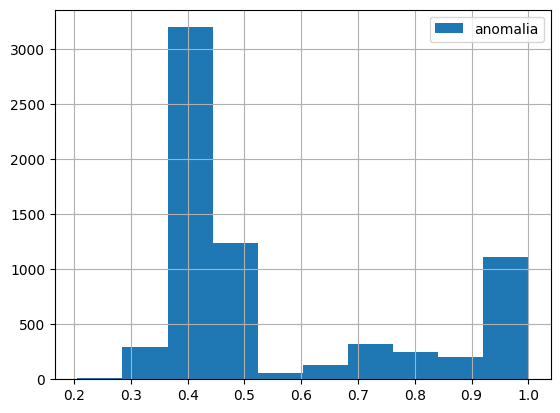

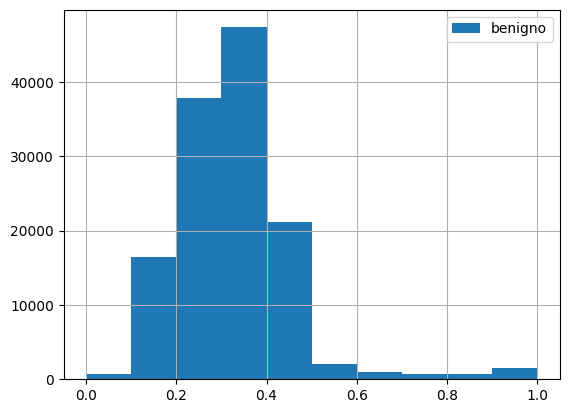

0.0 1.0
0.2056509208136713 0.9999999999902659


In [12]:
y_score_benigno  = pd.Series(y_score[y_val == BENIGN_LABEL])
y_score_anomalia = pd.Series(y_score[y_val == ANOMALY_LABEL])


y_score_anomalia.hist(label= "anomalia")
plt.legend()
plt.show()

y_score_benigno.hist(label= "benigno")
plt.legend()
plt.show()

print(y_score_benigno.min(),y_score_benigno.max())
print(y_score_anomalia.min(),y_score_anomalia.max())


In [13]:
y_pred_ = np.where(y_pred == 1, BENIGN_LABEL, ANOMALY_LABEL)
print(classification_report(y_val, y_pred_))
print(roc_auc_score(y_val, y_score))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89    129485
           1       0.15      0.62      0.24      6820

    accuracy                           0.81    136305
   macro avg       0.56      0.72      0.57    136305
weighted avg       0.93      0.81      0.86    136305

0.8670300231788983


In [14]:
print(classification_report(y_val, np.where(y_score > .35, 1, 0)))

              precision    recall  f1-score   support

           0       1.00      0.58      0.73    129485
           1       0.11      0.98      0.20      6820

    accuracy                           0.60    136305
   macro avg       0.55      0.78      0.47    136305
weighted avg       0.95      0.60      0.71    136305



In [16]:
with open('Models\melhorado\FirstStage.p', 'wb') as primeiro_estagio_file:
    pickle.dump(stage1, primeiro_estagio_file)

OSError: [Errno 22] Invalid argument: 'Models\reprodução\\FirsssstStage.p'